In [9]:
import inspect

import models

# Model Hashing for Implicit Versioning

In [67]:
lines = [l for l in inspect.getsource(models.LogisticRegression).split('\n')
         if l.strip()]


def annotate_comments(lines):
    in_multiline_comment = False
    for line in lines:
        stripped_line = line.strip()
        if in_multiline_comment:
            if stripped_line.endswith('"""'):
                in_multiline_comment = False
            yield line, True
        elif stripped_line.startswith('"""'):
            if stripped_line == '"""' or not stripped_line.endswith('"""'):
                in_multiline_comment = True
            yield line, True
        elif stripped_line.startswith('#'):
            yield line, True
        else:
            yield line, False


def strip_comments(lines):
    return (line for line, is_comment in annotate_comments(lines)
            if not is_comment)
        

list(strip_comments(lines))

['class LogisticRegression(MCMCLogisticRegression):',
 '    def __init__(self, m0=None, P0=None, **kwargs):',
 '        super().__init__(**kwargs)',
 '        self.m0 = m0',
 '        self.P0 = P0',
 '    def sample_from_prior(self):',
 '        return self.rng.multivariate_normal(self.m0, self.P0)',
 '    def fit(self, X, y):',
 '        P0_inv = np.linalg.inv(self.P0)',
 '        P0_inv_m0 = P0_inv.dot(self.m0)',
 '        kappas = (y - 0.5).T',
 '        XTkappa = X.T.dot(kappas)',
 '        num_predictors = X.shape[1]',
 '        beta_hat = np.ndarray((self.num_samples + 1, num_predictors))',
 '        beta_hat[0] = self.sample_from_prior()',
 '        self.beta_hat_ = beta_hat[1:]  # discard initial sample from prior',
 '        for i in range(1, self.num_samples + 1):',
 '            omegas = draw_omegas(X, beta_hat[i - 1], self.pg_rng)',
 '            V_omega = np.linalg.inv((X.T * omegas).dot(X) + P0_inv)',
 '            m_omega = V_omega.dot(XTkappa + P0_inv_m0)',
 '          

In [69]:
def hash_class(klass):
    source_lines = (l for l in inspect.getsource(klass).split('\n')
                    if l.strip())
    non_comment_source = ''.join(strip_comments(source_lines))
    return hash(non_comment_source)


hash_class(models.LogisticRegression)

1043483796943723520

In [ ]:
# TODO: could also implement a version of this that chains together source from all super classes

# Contextual bandit OpenAI Gym Environment Implementation

In [75]:
import gym

env = gym.make('CartPole-v0')
env.reset()

for t in range(1000):
    env.render()
    random_action = env.action_space.sample()
    obs, reward, done, info = env.step(random_action)
    if done:
        print(f"Episode finished after {t} timesteps")
        break

env.close()

Episode finished after 14 timesteps


In [76]:
env.action_space

Discrete(2)

In [77]:
env.observation_space

Box(4,)

In [78]:
env.observation_space.high

array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)

In [79]:
env.observation_space.low

array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32)

In [85]:
list(gym.envs.registry.all())[::50]

[EnvSpec(Copy-v0),
 EnvSpec(FetchPush-v1),
 EnvSpec(AirRaidDeterministic-v4),
 EnvSpec(AsterixNoFrameskip-v4),
 EnvSpec(BattleZone-ram-v4),
 EnvSpec(Boxing-ramDeterministic-v4),
 EnvSpec(ChopperCommand-ramNoFrameskip-v4),
 EnvSpec(ElevatorAction-v4),
 EnvSpec(FrostbiteDeterministic-v4),
 EnvSpec(IceHockeyNoFrameskip-v4),
 EnvSpec(Krull-ram-v4),
 EnvSpec(NameThisGame-ramDeterministic-v4),
 EnvSpec(Pooyan-ramNoFrameskip-v4),
 EnvSpec(Robotank-v4),
 EnvSpec(SpaceInvadersDeterministic-v4),
 EnvSpec(TutankhamNoFrameskip-v4),
 EnvSpec(WizardOfWor-ram-v4)]

In [96]:
spec = gym.envs.registry.spec('Hopper-v2')
{name: getattr(spec, name) for name in dir(spec)
 if not name.startswith('_')}

{'id': 'Hopper-v2',
 'make': <bound method EnvSpec.make of EnvSpec(Hopper-v2)>,
 'max_episode_seconds': None,
 'max_episode_steps': 1000,
 'nondeterministic': False,
 'reward_threshold': 3800.0,
 'tags': {'wrapper_config.TimeLimit.max_episode_steps': 1000},
 'timestep_limit': 1000,
 'trials': 100}

## Creating a new environment

I've pieced together the following from reading the `openai/gym` source code.

1.  A new environment can be registered by calling `gym.register(name, **kwargs)`
    1.  The name is a unique identifier string for the environment
    2.  The kwargs include a set of metadata. Some of this is optional. The important stuff seems to be:
        1.  `entry_point`: Environment class or full qualified path to the class (which will be loaded dynamically)
        2.  `trials`: number of trials to average reward over
        3.  `kwargs`: passed through to Environment class
        4.  `max_episode_steps`: seems to specify max number of time steps per replication / trial
2.  Once registered, a new instance can be created by calling `gym.make(name)`
    1.  This will create a new Environment instance by passing in `**kwargs` to `entry_point
3.  Every `Environment` needs:
    1.  to implement 5 methods:
        1.  `reset()`: reset state of environment, and return initial observation
        2.  `step(action)`: run one timestep, return tuple of `(observation, reward, done, info)`
        3.  `seed(seed=None)`: set seed for env's RNG
        4.  `close()`: perform any necessary cleanup operations
        5.  `render(mode='human')`: render env if supported. This is not required, but it may be useful to implement something later on.
    2.  to set 2-3 attributes:
        1.  `action_space`: Space object representing valid actions
        2.  `observation_space`: Space object representing valid observations
        3.  (optional) `reward_range`: tuple specifying (min, max) of possible rewards, e.g. (0, 1) for binary

### ContextualBanditEnvironment

Each of our environments will be fully-characterized by:

1.  Number of arms
2.  Number of time steps
3.  Context-generating distribution for decision instances (i.e. population characteristics)
    -   which naturally encodes the number of context variables & covariates
4.  True effects for each context covariate for each arm (assumed linear)
5.  Random seed

The link function will be Binomial-logistic for all our simulations for now. So rewards will be binary.

The action space will be `range(num_arms)`.

The observation space will correspond to the context-generating distribution.

#### First environment

For the first environment, we'll have:

1. 10 real-valued context variables, with no interactions
2. Homogeneous effect sizes (all same variance)
3. 10 arms
4. 100 time steps

9 of the arms will have exactly the same effects.
1 will have slightly better effects, so it is best for every context.
We will generate contexts to be stricly positive to make the setting of "better" effects as simple as increasing any of them.

In [128]:
from scipy import stats, special
import numpy as np
import pandas as pd

In [110]:
num_arms = 10
num_time_steps = 100
num_predictors = 10
shared_variance = 0.5

rng = np.random.RandomState(42)

In [111]:
# context-generating distribution
dist = stats.truncnorm(0, 10, loc=0, scale=shared_variance)
context = dist.rvs(num_predictors, random_state=rng)
context

array([0.2440635 , 0.98305592, 0.55383303, 0.41961388, 0.09840172,
       0.09838631, 0.03643071, 0.74959595, 0.42180713, 0.5269514 ])

In [125]:
rng.seed(42)
effect_dist = stats.norm(0, 0.5)
shared_effects = effect_dist.rvs(size=num_predictors, random_state=rng)
special.expit(shared_effects.dot(context))

0.6961117144835017

In [126]:
arm_effects = np.tile(shared_effects, 9).reshape(9, num_predictors)
np.all(arm_effects[0] == arm_effects[1])

True

In [127]:
better_effects = shared_effects.copy()
better_effects += stats.truncnorm.rvs(0, 0.1, loc=0, scale=0.1, size=num_predictors)
special.expit(better_effects.dot(context))

0.7015581484856768

In [142]:
all_effects = np.ndarray((10, 10))
all_effects[:-1] = arm_effects
all_effects[-1] = better_effects
all_effects.dot(pd.Series(context))

array([0.82885   , 0.82885   , 0.82885   , 0.82885   , 0.82885   ,
       0.82885   , 0.82885   , 0.82885   , 0.82885   , 0.85472868])

In [146]:
rewards = rng.binomial(n=1, p=_oh[142])
optimal_action = rewards.argmax()
optimal_reward = rewards[optimal_action]

1

In [166]:
s = gym.spaces.Box(low=0, high=np.inf, shape=(10,), dtype=np.float)
s.contains(np.array([10] * 11))

False

In [180]:
from experiment import Seedable


class ContextualBanditEnv(Seedable, gym.Env):

    def __init__(self, num_arms, num_predictors, num_time_steps, **kwargs):
        Seedable.__init__(self, **kwargs)  # implements seed and reset

        self.num_arms = num_arms
        self.num_predictors = num_predictors
        self.num_time_steps = num_time_steps

        self.action_space = gym.spaces.Discrete(num_arms)
        self.observation_space = gym.spaces.Box(
            low=0, high=np.inf, shape=(num_predictors,), dtype=np.float)
        self.reward_range = (0, 1)

        self._current_time_step = 0
        self._last_observation = None

        shared_variance = 0.5
        self.context_dist = stats.truncnorm(0, 10, loc=0, scale=shared_variance)

        # Set up arm effects.
        self.arm_effects = np.ndarray((num_arms, num_predictors))

        # All but one of the arms will have the same effects.
        effect_dist = stats.norm(0, 0.5)
        shared_effects = effect_dist.rvs(size=num_predictors, random_state=self.rng)
        self.arm_effects[:-1] = (np.tile(shared_effects, num_arms - 1)
                                   .reshape(num_arms - 1, num_predictors))

        # The last one will have just slightly better effects.
        self.arm_effects[-1] += shared_effects + stats.truncnorm.rvs(
            0, 0.1, loc=0, scale=0.1, size=num_predictors, random_state=self.rng)

    def _next_context(self):
        context = self.context_dist.rvs(size=self.num_predictors, random_state=self.rng)
        self._last_observation = pd.Series(context)
        self._current_time_step += 1
        return self._last_observation

    def reset(self):
        Seedable.reset(self)
        return self._next_context()

    def step(self, action):
        rates = special.expit(self.arm_effects.dot(self._last_observation))
        rewards = self.rng.binomial(n=1, p=rates)
        optimal_action = rewards.argmax()
        optimal_reward = rewards[optimal_action]
        actual_reward = rewards[action]

        info = dict(optimal_action=optimal_action,
                    optimal_reward=optimal_reward)
        next_observation = self._next_context()
        done = self._current_time_step == self.num_time_steps
        
        return next_observation, actual_reward, done, info

In [181]:
gym.envs.register('CMABRealsOnebestN10P10T100-v4', trials=100, max_episode_steps=100,
             entry_point=ContextualBanditEnv, kwargs=dict(
                 num_arms=10, num_predictors=10, num_time_steps=100, seed=42))

In [182]:
cmab_env = gym.envs.make('CMABRealsOnebestN10P10T100-v4')
cmab_env

<TimeLimit<ContextualBanditEnv<CMABRealsOnebestN10P10T100-v4>>>

In [183]:
obs = cmab_env.reset()

all_rewards = np.ndarray((num_time_steps,))
optimal_rewards = np.ndarray((num_time_steps,))

for t in range(100):
    random_action = cmab_env.action_space.sample()
    obs, reward, done, info = cmab_env.step(random_action)
    all_rewards[t] = reward
    optimal_rewards[t] = info['optimal_reward']
    if done:
        print(f"Episode finished after {t} timesteps")
        break

regret = optimal_rewards - all_rewards
np.sum(regret)

Episode finished after 98 timesteps


41.0

In [184]:
from experiment import plot_cum_regret

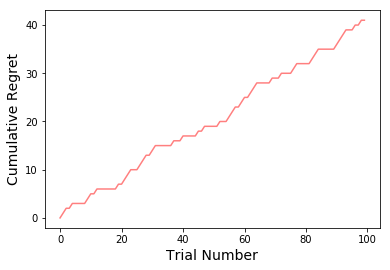

In [187]:
plot_cum_regret(all_rewards, optimal_rewards);